In [4]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net import create_train_state, train, neural_ode

In [11]:
import importlib
import neural_net

importlib.reload(neural_net)

create_train_state, train, neural_ode = neural_net.create_train_state, neural_net.train, neural_net.neural_ode

In [12]:
n_points = 200
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

## Odeint Neural ODE @jit

In [13]:
y0 = jnp.array([0.0, 1.0])
layer_widths = [3, 100, 100, 2]
learning_rate = 1e-3
    
y_pred_results = {}

for i, noise_level in enumerate([0.0, 0.1, 0.2, 0.5]):

    # generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    # create the new state
    rng = random.PRNGKey(0)
    state = create_train_state(rng, layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_state = train(state, t, y_noisy, y0)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    y_pred = neural_ode(trained_state.params, y0, t, trained_state)
    y_pred_results[str(i)] = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}

Epoch 0, Loss: 1.7071919441223145
Epoch 100, Loss: 0.5608386993408203
Epoch 200, Loss: 0.121159128844738
Epoch 300, Loss: 0.046878937631845474
Epoch 400, Loss: 0.034465692937374115
Epoch 500, Loss: 0.04523362219333649
Epoch 600, Loss: 0.025192929431796074
Epoch 700, Loss: 0.035935286432504654
Epoch 800, Loss: 0.03182542324066162
Epoch 900, Loss: 0.041076529771089554
Time elapsed: 82.79071998596191
Epoch 0, Loss: 1.706992745399475
Epoch 100, Loss: 0.571145236492157
Epoch 200, Loss: 0.13327635824680328
Epoch 300, Loss: 0.09091471135616302
Epoch 400, Loss: 0.08691529929637909
Epoch 500, Loss: 0.08410031348466873
Epoch 600, Loss: 0.09082305431365967
Epoch 700, Loss: 0.0851258859038353
Epoch 800, Loss: 0.08163048326969147
Epoch 900, Loss: 0.08550862222909927
Time elapsed: 82.58541703224182
Epoch 0, Loss: 1.7088090181350708
Epoch 100, Loss: 0.589834451675415
Epoch 200, Loss: 0.17842884361743927
Epoch 300, Loss: 0.16399508714675903
Epoch 400, Loss: 0.16890981793403625
Epoch 500, Loss: 0.16082

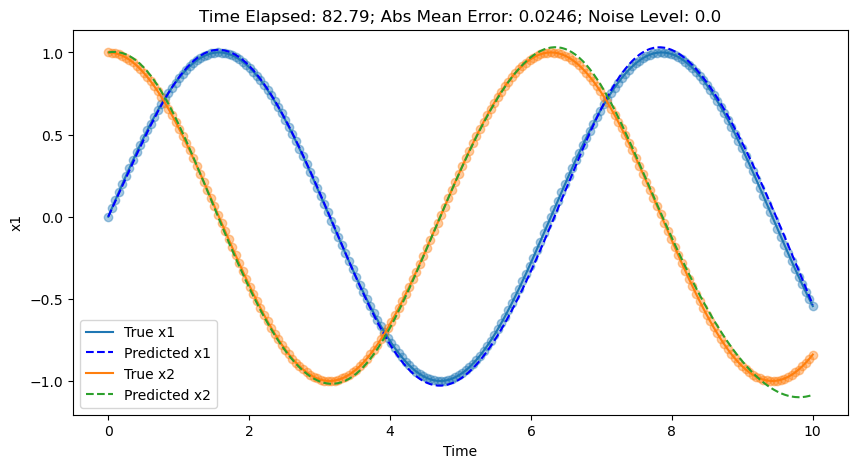

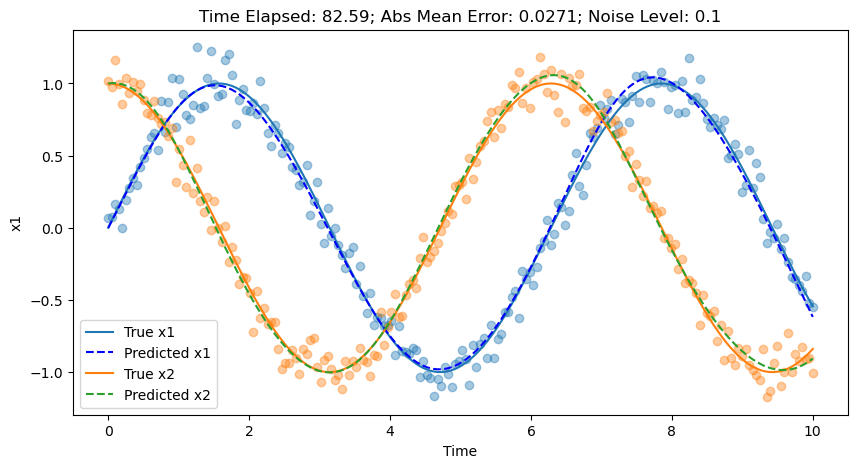

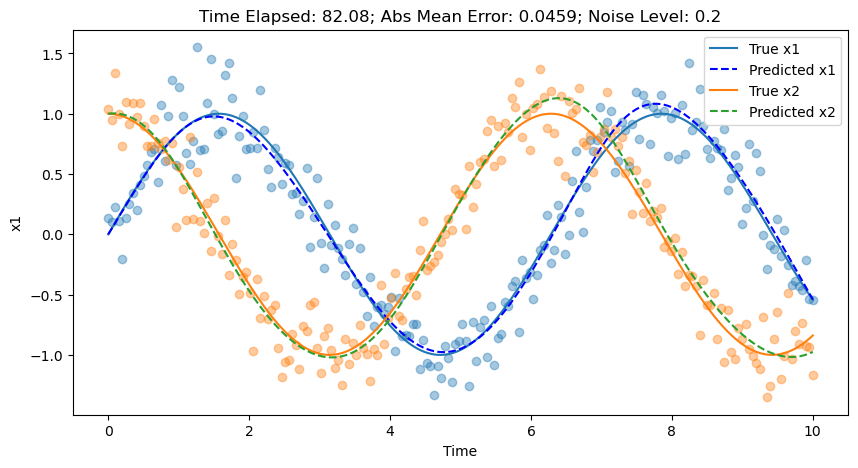

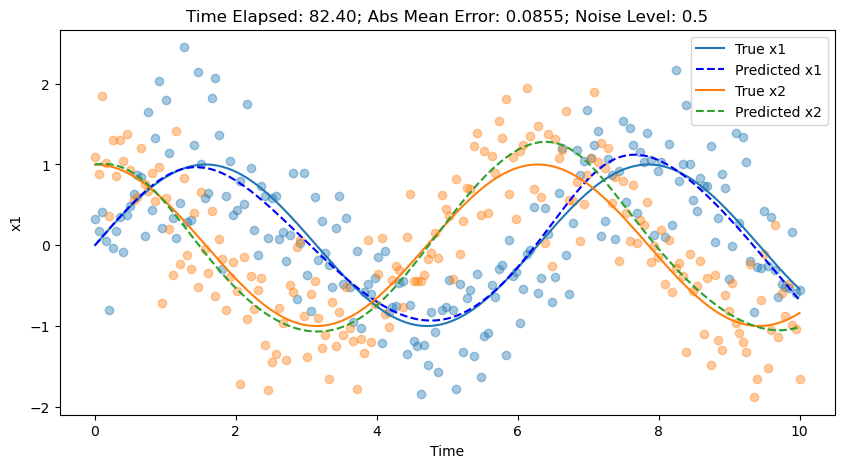

In [15]:
for i in range(len(y_pred_results)):
    result = y_pred_results[str(i)]
    y_pred = result["predictions"]
    y_noisy = result["y_noisy"]
    plt.figure(figsize=(10, 5))
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.4)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    ame = jnp.mean(jnp.abs(y_pred - y))
    plt.title(f'Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {ame:.4f}; Noise Level: {result["noise_level"]}')
    plt.show()

## Collocation Based Odeint

In [16]:
def integrate_derivative(t, dy_dt, y0):
    y = jnp.zeros_like(dy_dt)
    y = y.at[0].set(y0)
    for i in range(1, len(dy_dt)):
        dt = t[i] - t[i - 1]
        y = y.at[i].set(y[i - 1] + dy_dt[i - 1] * dt)
    return y

In [17]:
from neural_net import create_train_state_collocation, train_collocation, predict_derivatives

y0 = jnp.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3
    
y_pred_results_collocation = {}
non_param_collocation_results = {}

for i, noise_level in enumerate([0.0, 0.1, 0.2, 0.5]):

    # generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)
    non_param_collocation_results[str(i)] = {"y_true":y, "y_noisy": y_noisy, "t":t, "noise_level": noise_level, "estimated_derivative":estimated_derivative, "estimated_solution":estimated_solution}
    
    # create the new state
    rng = random.PRNGKey(0)
    input_shape = (2, )
    state = create_train_state_collocation(rng, layer_widths, input_shape, learning_rate)
    
    start_timer = time.time()
    # train_collocation(state_coll, t2, estimated_derivative.T, num_epochs= 10000)
    t_t = jnp.array([t,t])
    trained_state = train_collocation(state, t_t.T, estimated_derivative.T, num_epochs=10000)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")
    
    # generate predictions
    dy_dt_pred = predict_derivatives(trained_state, t_t.T)
    y_pred = integrate_derivative(t_t.T, dy_dt_pred, y0)
    
    y_pred_results_collocation[str(i)] = {"dy_dt_predictions": dy_dt_pred, "y_pred": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy":y_noisy}
    

Epoch 0, Loss: 0.6563237905502319
Epoch 1000, Loss: 0.06968510150909424
Epoch 2000, Loss: 0.028240809217095375
Epoch 3000, Loss: 0.010666217654943466
Epoch 4000, Loss: 0.01619458571076393
Epoch 5000, Loss: 0.012794731184840202
Epoch 6000, Loss: 0.016459105536341667
Epoch 7000, Loss: 0.008233793079853058
Epoch 8000, Loss: 0.014916965737938881
Epoch 9000, Loss: 0.009576449170708656
Time elapsed: 3.203701972961426
Epoch 0, Loss: 0.651178240776062
Epoch 1000, Loss: 0.07592812180519104
Epoch 2000, Loss: 0.06270572543144226
Epoch 3000, Loss: 0.057093095034360886
Epoch 4000, Loss: 0.05049210041761398
Epoch 5000, Loss: 0.04134631156921387
Epoch 6000, Loss: 0.03608512133359909
Epoch 7000, Loss: 0.03317508473992348
Epoch 8000, Loss: 0.031008196994662285
Epoch 9000, Loss: 0.026804795488715172
Time elapsed: 3.1814041137695312
Epoch 0, Loss: 0.6724408864974976
Epoch 1000, Loss: 0.14224956929683685
Epoch 2000, Loss: 0.117245614528656
Epoch 3000, Loss: 0.09520388394594193
Epoch 4000, Loss: 0.07844718

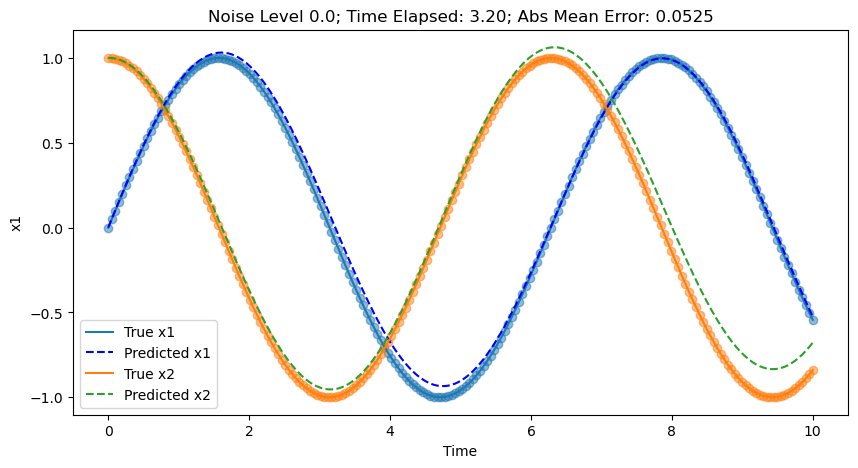

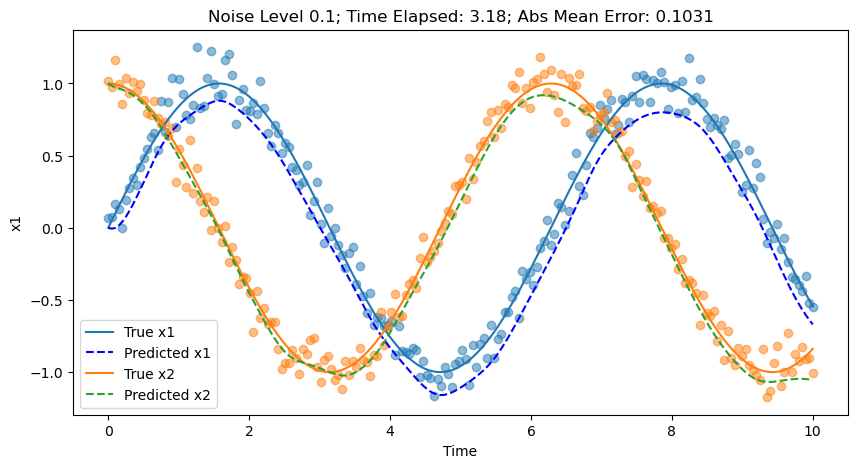

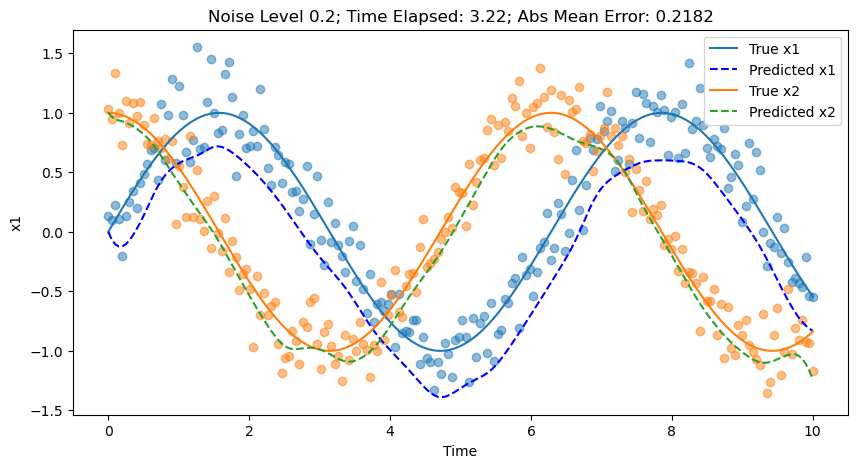

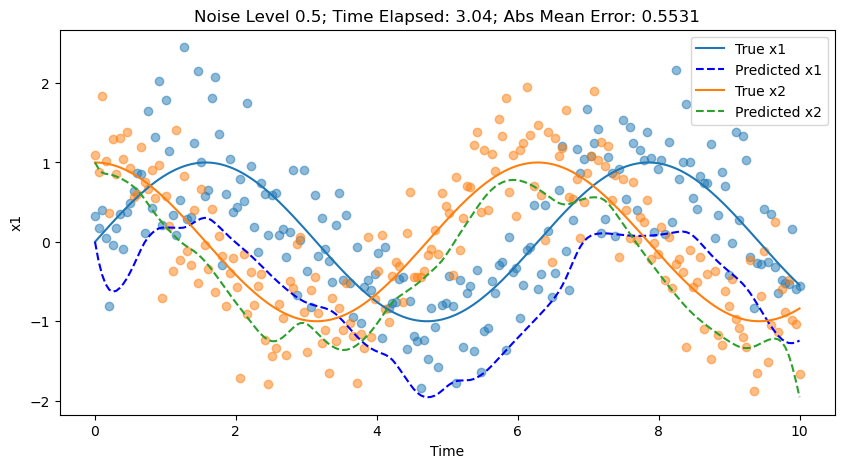

In [19]:
for i in range(len(y_pred_results_collocation)):
    result = y_pred_results_collocation[str(i)]
    
    y_pred = result["y_pred"]
    y_noisy = result["y_noisy"]
    plt.figure(figsize=(10, 5))
    
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.5)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.5)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    ame = jnp.mean(jnp.abs(y_pred - y))
    plt.title(f'Noise Level {result["noise_level"]}; Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {ame:.4f}')
    plt.show()